In [4]:
import os;
import sys;
import random;
import json

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;

import tensorflow as tf
from tensorflow import keras;
import openslide
import imutils

import pylab




from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel;
import skimage
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

from skimage.filters.rank import entropy
from skimage.morphology import disk

from skimage.feature import local_binary_pattern




from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel;
import skimage
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


import cv2;

import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color


from skimage.filters.rank import entropy
from skimage.morphology import disk



from skimage.filters import meijering,  frangi, hessian
from skimage.filters import meijering, sato

In [5]:
nuclei_dir="/home/ubuntu/data/nuclei_dsbowl/"

In [8]:


train_ids=os.listdir(nuclei_dir+"/train");
test_ids=os.listdir(nuclei_dir+"/test");
test_ids2=os.listdir(nuclei_dir+"/test_final");


train_ids=list(set(train_ids))
test_ids=list(set(test_ids))
test_ids2=list(set(test_ids2))


print(len(train_ids))
print(len(test_ids))
print(len(test_ids2))

670
65
3019


In [36]:
class DataGen(keras.utils.Sequence):
    def __init__(self,ids,batch_size=0,image_size=(256,256),path="",funct=""):
        self.ids=ids;
        self.path = path
        self.batch_size =batch_size;
        self.image_size = image_size;
        self.funct = funct;
        
    def __load__(self,id_name):
        
        path=self.path;
        
        image_path = os.path.join(path,id_name,"images",id_name)+".png";
        
        image = cv2.imread(image_path);
        
        mask = np.zeros( (image.shape[0],image.shape[1]) );
        
        mask_path= os.path.join(path,id_name,"masks")
        all_masks = os.listdir(mask_path);
        for name in all_masks:
            _mask_path = os.path.join(mask_path,name);
            _mask_image = cv2.imread(_mask_path,-1);
            thresh =0.5
            _mask_image = cv2.threshold(_mask_image, thresh, 255, cv2.THRESH_BINARY)[1]

            mask =np.maximum(mask,_mask_image);
        
        
        image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
        
        image = cv2.resize(image,self.image_size);
        
        mask=cv2.resize(mask,self.image_size);
        
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);
        image2=image.copy();
        if self.funct=="":
            image =image/255.0;
            
        elif self.funct=="sobal":
            deep=cv2.CV_32F;
            x=cv2.Sobel(image2,deep,1,0)
            y=cv2.Sobel(image2,deep,0,1)

            absx= cv2.convertScaleAbs(x)
            absy= cv2.convertScaleAbs(y)

            dist = cv2.addWeighted(absx,0.5,absy,0.5,0)
            #dist_gray = cv2.cvtColor(dist, cv2.COLOR_RGB2GRAY);
            #image = dist_gray;
            
            image =image/255.0;
            
        elif self.funct=="lap":
            deep=cv2.CV_32F;
            lap = cv2.Laplacian(image2,deep,3)
            lap = cv2.convertScaleAbs(lap);
            #lap_gray = cv2.cvtColor(lap, cv2.COLOR_RGB2GRAY);
            #image=lap_gray;
            
            image =image/255.0;
            
        elif self.funct=="edge_roberts":
            image[:,:,0] = filters.roberts(image2[:,:,0])
            image[:,:,1] = filters.roberts(image2[:,:,1])
            image[:,:,2] = filters.roberts(image2[:,:,2])
            
        elif self.funct=="edge_sobel":
            image[:,:,0] = filters.sobel(image2[:,:,0])
            image[:,:,1] = filters.sobel(image2[:,:,1])
            image[:,:,2] = filters.sobel(image2[:,:,2])
            
        elif self.funct=="edge_scharr":
            
            image[:,:,0] = filters.scharr(image2[:,:,0])
            image[:,:,1] = filters.scharr(image2[:,:,1])
            image[:,:,2] = filters.scharr(image2[:,:,2])
            
        elif self.funct=="edge_prewitt":
            image[:,:,0] = filters.prewitt(image2[:,:,0])
            image[:,:,1] = filters.prewitt(image2[:,:,1])
            image[:,:,2] = filters.prewitt(image2[:,:,2])
        elif self.funct=="canny":
            canny1 = skimage.feature.canny(gray,sigma=1) 
            image[:,:,0]=canny1*1.0;
            canny2 = skimage.feature.canny(gray,sigma=3) 
            image[:,:,1]=canny2*1.0;
            
            canny3 = skimage.feature.canny(gray,sigma=5) 
            image[:,:,2]=canny3*1.0;
        
            
        elif self.funct=="entropy":
            res = entropy(gray, disk(2))
            res = res/np.max(res)
            image[:,:,0]=res
            res = entropy(gray, disk(5))
            res = res/np.max(res)
            image[:,:,1]=res
            
            res = entropy(gray, disk(10))
            res = res/np.max(res)
            image[:,:,2]=res
            
            
        
        elif self.funct=="lbp":
            radius = 8
            n_points = 20 * radius

            lbp1 = local_binary_pattern(gray, n_points, radius, "uniform")
            
            lbp1=lbp1/np.max(lbp1);
            
            radius = 3
            n_points = 8 * radius

            lbp2 = local_binary_pattern(gray, n_points, radius, "uniform")
            
            lbp2=lbp2/np.max(lbp2);
            
            
            radius = 10
            n_points = 25 * radius

            lbp3 = local_binary_pattern(gray, n_points, radius, "uniform")
            
            lbp3=lbp3/np.max(lbp3);
            
            image[:,:,0]=lbp1;
            image[:,:,1]=lbp2;
            image[:,:,2]=lbp3;
            
        
        elif self.funct=="coner":
            dst = cv2.cornerHarris(image[:,:,0],2,3,0.01)
            dst = cv2.dilate(dst,None)
            ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
            
            image[:,:,0]=dst/255.0;
            
            
            dst = cv2.cornerHarris(image[:,:,1],2,3,0.01)
            dst = cv2.dilate(dst,None)
            ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
            
            image[:,:,1]=dst/255.0;
            
            
            dst = cv2.cornerHarris(image[:,:,2],2,3,0.01)
            dst = cv2.dilate(dst,None)
            ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
            
            image[:,:,2]=dst/255.0;
            
        elif self.funct=="meijering":
            res = skimage.filters.meijering(image)
            
            image=res;
        elif self.funct=="frangi":
            res = skimage.filters.frangi(image)
            
            image=res;
        elif self.funct=="hessian":
            res = skimage.filters.hessian(image)
            
            image=res;
            
        elif self.funct=="sato":
            res = skimage.filters.sato(image)
            
            image=res;
        
        
        mask = mask/255.0;
        
        
        
        return image, mask;
    
    def __getitem__(self,index):
        if (index+1)*self.batch_size >len(self.ids):
            self.bach_size=len(self.ids)-index*batch_size;
            
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size]
        
        image=[];
        mask=[];
        
        for id_name in files_batch:
            _img,_mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask);
        
        image =np.array(image)
        mask =np.array(mask);
        
        return image, mask;
    
    def on_epoch_end(self):
        pass;
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));

In [37]:
image_size = (512,512);
batch_size = 10

In [38]:
test_data = DataGen(train_ids,batch_size=batch_size,image_size = image_size,path=nuclei_dir+"/train",funct="meijering")


(10, 512, 512, 3) (10, 512, 512)


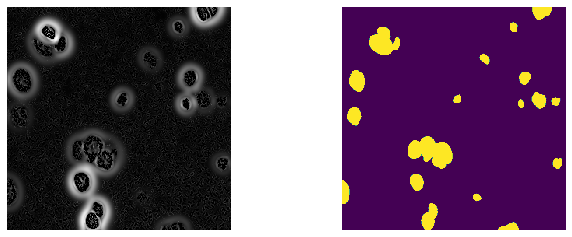

In [39]:

x,y = test_data.__getitem__(0)

print(x.shape,y.shape)

r=random.randint(0,len(x)-1);

fig = plt.figure(figsize=(10,10));
fig.subplots_adjust(hspace=0.5,wspace=0.5)
ax = fig.add_subplot(1,2,1)
ax.axis("off")
ax.imshow(x[r][:,:])
ax = fig.add_subplot(1,2,2)
ax.axis("off")
ax.imshow(np.reshape(y[r],image_size))



In [40]:
def down_block(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    p = keras.layers.MaxPool2D((2,2),(2,2))(c);
    
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),padding="same",strides=1):
    us=keras.layers.UpSampling2D((2,2))(x);
    concat = keras.layers.Concatenate()([us,skip])
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(concat);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    return c;


def bottleneck(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    return c;

In [41]:
def UNet():
    f = [16,32,64,128,256,512];
    
    inputs = keras.layers.Input(image_size+(3,))
    
    p0=inputs;
    c1,p1 = down_block(p0,f[0])  
    c2,p2 = down_block(p1,f[1]) 
    c3,p3 = down_block(p2,f[2])
    
    bn = bottleneck(p3,f[3])
    
    u3= up_block(bn,c3,f[2])
    u2= up_block(u3,c2,f[1])
    u1= up_block(u2,c1,f[0])
    
    outputs = keras.layers.Conv2D(1,(1,1),padding="same",activation='sigmoid')(u1);
    model = keras.models.Model(inputs,outputs)
    
    return model

In [42]:

smooth=1
def dice_coef(y_true,y_pred):
    
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f* y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+ smooth )
    
def dice_coef_loss(y_true,y_pred):
    return 1.0- dice_coef(y_true,y_pred)

In [43]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [44]:
functs=["sobal","lap","edge_roberts","edge_sobel","edge_scharr","edge_prewitt","canny","entropy","lbp","coner","meijering","frangi","hessian","sato"];

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [46]:
results=[];

In [ ]:

for funct in functs:
    
    valids= random.sample(train_ids,100);
    traids= [x for x in train_ids if x not in valids];
    train_data = DataGen(traids,batch_size=batch_size,image_size = image_size,path=nuclei_dir+"/train",funct=funct)
    valid_data = DataGen(valids,batch_size=batch_size,image_size = image_size,path=nuclei_dir+"/train",funct=funct)
    
    train_steps= len(traids)//batch_size;
    valid_steps= len(valids)//batch_size;
    
    epochs = 50;
    
    model = UNet();
    model.compile(optimizer = "adam",loss="binary_crossentropy",metrics=['acc',f1_m,precision_m, recall_m,dice_coef_loss]);
    checkpoint = ModelCheckpoint('model_test_'+funct+'_check.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    #model.load_weights("model_test_check.hdf5")
    result = model.fit_generator(train_data, validation_data=valid_data, 
                                 steps_per_epoch=train_steps, 
                                 validation_steps=valid_steps, 
                                 epochs=epochs,callbacks=[checkpoint]
                                )
    results.append(result)
    model.save("filter_test_"+funct+"_model.hdf5")

Epoch 1/50
56/57 [============================>.] - ETA: 10s - loss: 0.4134 - acc: 0.8267 - f1_m: 0.0240 - precision_m: 0.2130 - recall_m: 0.0308 - dice_coef_loss: 0.7293
Epoch 00001: val_loss improved from inf to 0.17860, saving model to model_test_sobal_check.hdf5
57/57 [==============================] - 608s 11s/step - loss: 0.4106 - acc: 0.8267 - f1_m: 0.0235 - precision_m: 0.2093 - recall_m: 0.0302 - dice_coef_loss: 0.7270 - val_loss: 0.1786 - val_acc: 0.8863 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_dice_coef_loss: 0.6165
Epoch 2/50
56/57 [============================>.] - ETA: 10s - loss: 0.1984 - acc: 0.8908 - f1_m: 0.4919 - precision_m: 0.6501 - recall_m: 0.4429 - dice_coef_loss: 0.4473
Epoch 00002: val_loss improved from 0.17860 to 0.11869, saving model to model_test_sobal_check.hdf5
57/57 [==============================] - 610s 11s/step - loss: 0.1963 - acc: 0.8920 - f1_m: 0.4984 - precision_m: 0.6536 - recall_m: 0.4503 - dice_coef

In [75]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 512, 512, 16) 448         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 512, 512, 16) 2320        conv2d_210[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_42 (MaxPooling2D) (None, 256, 256, 16) 0           conv2d_211[0][0]                 
___________________________________________________________________________________________

In [56]:
print("test")

test


In [60]:
history={}

for i in range(len(results)):
    history[functs[i]]=results[i].history

for i in history:
    for j in history[i]:
        history[i][j]=[float(x) for x in history[i][j]]

In [61]:
with open('testhistory.json', 'w') as outfile:
    json.dump(history, outfile)

In [62]:
result=dict();
for i in history:
    acc =history[i]["acc"]
    val_acc = history[i]["val_acc"]
    maxacc = np.max(acc)
    maxval_acc = np.max(val_acc)
    result[i]={"acc":maxacc,"val_acc":maxval_acc}

In [63]:
result

{'sobal': {'acc': 0.9589971303939819, 'val_acc': 0.9703651666641235},
 'lap': {'acc': 0.9607007503509521, 'val_acc': 0.9583631753921509},
 'edge_roberts': {'acc': 0.8462340235710144, 'val_acc': 0.8525139093399048},
 'edge_sobel': {'acc': 0.8452029824256897, 'val_acc': 0.8583913445472717},
 'edge_scharr': {'acc': 0.8476261496543884, 'val_acc': 0.8445785641670227},
 'edge_prewitt': {'acc': 0.8462477326393127, 'val_acc': 0.8524353504180908},
 'canny': {'acc': 0.958488404750824, 'val_acc': 0.9501284956932068},
 'entropy': {'acc': 0.9595116376876831, 'val_acc': 0.9363231062889099},
 'lbp': {'acc': 0.9584088325500488, 'val_acc': 0.9495339393615723},
 'coner': {'acc': 0.9099907279014587, 'val_acc': 0.8904367685317993},
 'meijering': {'acc': 0.9577433466911316, 'val_acc': 0.9563258290290833},
 'frangi': {'acc': 0.8469933271408081, 'val_acc': 0.8483854532241821},
 'hessian': {'acc': 0.9562423825263977, 'val_acc': 0.9482980370521545},
 'sato': {'acc': 0.9530283212661743, 'val_acc': 0.94923812150

In [67]:
import pandas as pd

with open('test.json', 'w') as outfile:
    json.dump(result, outfile)
    

patients_df = pd.read_json("test.json")
patients_df.head()

,Sobel,Laplace,Edge roberts,Edge sobel,Edge scharr,Edge prewitt,canny,Entropy,LBP,Harris Corner,Meijering,Frangi,Hessian,Sato
acc,0.800514,0.816339,0.494827,0.494072,0.498036,0.493685,0.739084,0.619549,0.636498,0.724466,0.794418,0.494487,0.769441,0.670771
val_acc,0.786440,0.810423,0.422811,0.433018,0.527381,0.514861,0.756251,0.592205,0.633134,0.637588,0.799802,0.467876,0.706150,0.706679


In [65]:
result={'Sobel': {'acc': 0.8005135655403137, 'val_acc': 0.7864398956298828},
 'Laplace': {'acc': 0.8163390159606934, 'val_acc': 0.8104232549667358},
 'Edge roberts': {'acc': 0.4948265552520752, 'val_acc': 0.4228111207485199},
 'Edge sobel': {'acc': 0.49407196044921875, 'val_acc': 0.4330177307128906},
 'Edge scharr': {'acc': 0.49803557991981506, 'val_acc': 0.5273811221122742},
 'Edge prewitt': {'acc': 0.4936849772930145, 'val_acc': 0.5148609280586243},
 'canny': {'acc': 0.7390839457511902, 'val_acc': 0.7562507390975952},
 'Entropy': {'acc': 0.6195487976074219, 'val_acc': 0.5922050476074219},
 'LBP': {'acc': 0.6364982724189758, 'val_acc': 0.6331340670585632},
 'Harris Corner': {'acc': 0.7244663238525391, 'val_acc': 0.6375881433486938},
 'Meijering': {'acc': 0.7944179177284241, 'val_acc': 0.7998020052909851},
 'Frangi': {'acc': 0.4944869577884674, 'val_acc': 0.46787604689598083},
 'Hessian': {'acc': 0.7694411873817444, 'val_acc': 0.7061504125595093},
 'Sato': {'acc': 0.6707708835601807, 'val_acc': 0.7066791653633118}}


In [66]:
labels=list(result.keys())
acc=[];
val_acc=[]
for i in labels:
    acc.append(result[i]['acc'])
    val_acc.append(result[i]['val_acc'])

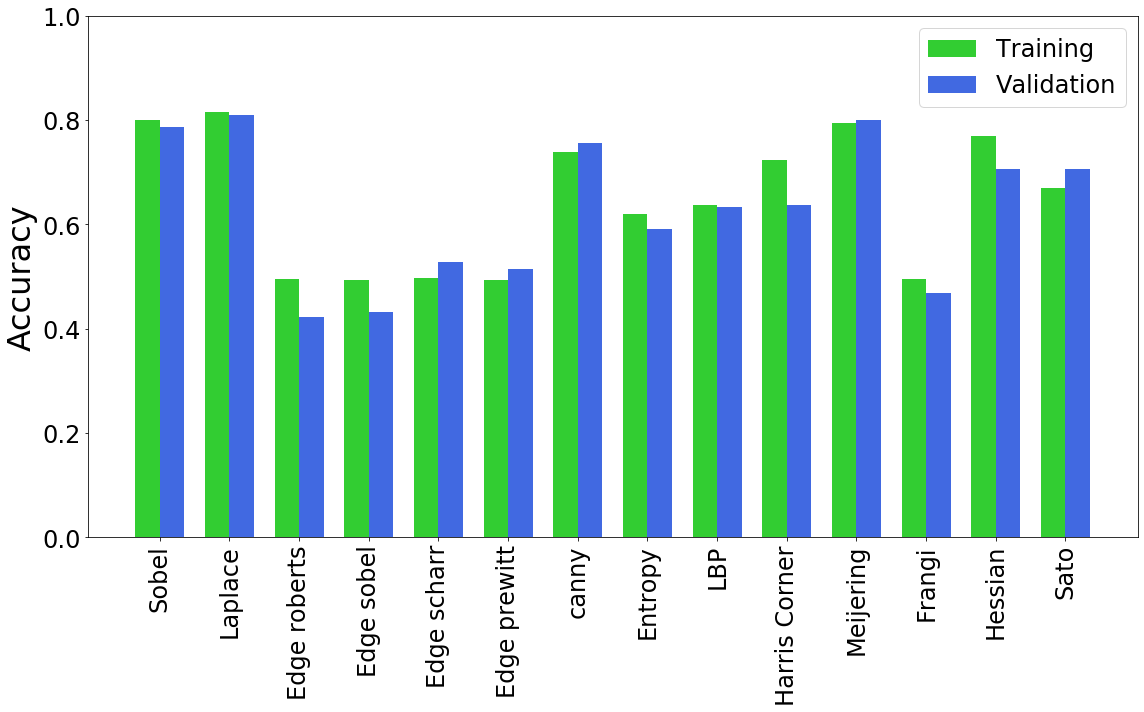

In [74]:
fig = plt.figure(figsize=(16,10));





x = np.arange(len(labels))  # the label locations
width = 0.35

ax = fig.add_subplot(1,1,1)



ax.set_ylim([0,1])
ax.set_ylabel('Accuracy', fontsize=32)
plt.xticks(fontsize=24 )
plt.yticks(fontsize=24 )

rects1 = ax.bar(x - width/2, acc, width, label='Training',color='limegreen')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation',color='royalblue')


ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)

ax.legend(prop=dict(size=24))



fig.tight_layout()